In [3]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from collections import Counter

In [7]:
final_dataset__file_path = '/content/drive/MyDrive/Dataset/Final_Dataset/final_dataset_with_labels_v4.csv'

In [8]:
raw_df = pd.read_csv(final_dataset__file_path)
raw_df.tail()

,SYM_ROOT,DATE,pre_market_volume,post_market_volume,DAY_OF_WEEK,OPEN,HIGH,LOW,CLOSE,VOLUME
6711,VTI,2020-02-24,895644.0,169321.0,Monday,152.459116,153.728832,151.615721,152.273758,8710900.0
6712,VTI,2020-02-25,364623.0,334185.0,Tuesday,152.959566,153.283952,147.148521,147.621185,10112300.0
6713,VTI,2020-02-26,440509.0,213189.0,Wednesday,148.297741,149.965989,146.434872,146.805588,8210300.0
6714,VTI,2020-02-27,961030.0,331541.0,Thursday,143.691554,145.999299,140.317991,140.373611,14384200.0
6715,VTI,2020-02-28,1682164.0,494707.0,Friday,135.702501,139.567268,134.664486,139.428253,22272400.0


# Utility Functions

In [9]:
# Function to calculate percentage increment
def calculate_percentage_increment(df, col, window):
    df = df.sort_values(by="DATE")
    df[f"{col}_avg_{window}"] = df[col].rolling(window=window, min_periods=window).mean().shift(1)

    df[f"{col}_avg_{window}_increment"] = ((df[col] - df[f"{col}_avg_{window}"]) / df[f"{col}_avg_{window}"]) * 100

    return df

In [10]:
def calculate_percentage_increment_for_pre_post(df):
  # Apply the function for pre-market
  df = calculate_percentage_increment(df, "pre_market_volume", 3)
  df = calculate_percentage_increment(df, "pre_market_volume", 5)
  df = calculate_percentage_increment(df, "pre_market_volume", 9)
  df = calculate_percentage_increment(df, "pre_market_volume", 12)

  # Apply the function for post-market volumes
  df = calculate_percentage_increment(df, "post_market_volume", 3)
  df = calculate_percentage_increment(df, "post_market_volume", 5)
  df = calculate_percentage_increment(df, "post_market_volume", 9)
  df = calculate_percentage_increment(df, "post_market_volume", 12)
  return df

In [11]:
def calculate_the_percentage_increment_open_close(df):
  df = calculate_percentage_increment(df, 'OPEN',3)
  df = calculate_percentage_increment(df, 'OPEN',5)

  df = calculate_percentage_increment(df, 'CLOSE',3)
  df = calculate_percentage_increment(df, 'CLOSE',5)

  df = calculate_percentage_increment(df, 'HIGH',3)
  df = calculate_percentage_increment(df, 'CLOSE',3)

  return df

In [12]:
def visualize_histogram_with_percentiles(df, percentile_values=[0.05, 0.10, 0.90, 0.95]):

  # Calculate percentiles
  percentiles = percentile_values
  percentile_values = {p: df["average_increment_per_day"].quantile(p) for p in percentiles}

  # Plot the histogram
  plt.figure(figsize=(10, 6))
  plt.hist(df["average_increment_per_day"].dropna(), bins=50, edgecolor='black', alpha=0.7, label="Distribution")

  # Add vertical lines for percentiles
  for p, value in percentile_values.items():
      plt.axvline(value, color='r', linestyle='dashed', linewidth=2, label=f"{int(p*100)}th Percentile ({value:.2f}%)")

  # Labels and title
  plt.xlabel("Average Increment Per Day (%)")
  plt.ylabel("Frequency")
  plt.title("Distribution of Average Increment Per Day with Key Percentiles")
  plt.legend()
  plt.grid(axis="y", linestyle="--", alpha=0.7)
  plt.show()

In [13]:
def retrieve_the_Labels(df):

  # Define labels based on percentiles
  df["label"] = "Neutral"  # Default label

  percentile_values = [0.05, 0.10, 0.90, 0.95]
  percentile_values_all = {p: df["average_increment_per_day"].quantile(p) for p in percentile_values}

  # Assign labels based on thresholds
  df.loc[df["average_increment_per_day"] >= percentile_values_all[0.90], "label"] = "Buy"
  df.loc[df["average_increment_per_day"] >= percentile_values_all[0.95], "label"] = "Strong Buy"
  df.loc[df["average_increment_per_day"] <= percentile_values_all[0.10], "label"] = "Sell"
  df.loc[df["average_increment_per_day"] <= percentile_values_all[0.05], "label"] = "Strong Sell"

In [14]:
def create_the_labels(df):
  df['average_increment_per_day'] = (df['CLOSE'] - df['OPEN'])*100/df['OPEN']
  retrieve_the_Labels(df)
  return df

In [15]:
def preprocess_for_ml(df, categorical_columns, boolean_columns=[]):
    """
    Preprocess the DataFrame for ML by:
    - One-hot encoding categorical columns.
    - Converting boolean columns to numerical (0/1).

    Args:
        df (pd.DataFrame): The dataset to preprocess.
        categorical_columns (list): List of categorical column names to one-hot encode.
        boolean_columns (list): List of boolean column names to convert to numerical.

    Returns:
        pd.DataFrame: The preprocessed DataFrame.
    """
    # One-hot encode categorical columns
    df = pd.get_dummies(df, columns=categorical_columns, drop_first=False)

    # Convert boolean columns to integers (0/1)
    for col in boolean_columns:
        if df[col].dtype == 'bool':
            df[col] = df[col].astype(int)

    return df


# Testing for AAPL Stocks

In [ ]:
# Extract the AAPL Dataset for preprocessing
df_aapl = raw_df[raw_df['SYM_ROOT'] == 'AAPL']

In [ ]:
# Convert DATE column to datetime format
df_aapl["DATE"] = pd.to_datetime(df_aapl["DATE"])

<ipython-input-14-aa3316ad7a71>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aapl["DATE"] = pd.to_datetime(df_aapl["DATE"])


## Feature Preprocessing

In [ ]:
df_aapl = calculate_percentage_increment_for_pre_post(df_aapl)

In [ ]:
df_aapl.columns

Index(['SYM_ROOT', 'DATE', 'pre_market_volume', 'post_market_volume',
       'DAY_OF_WEEK', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME',
       'pre_market_volume_avg_3', 'pre_market_volume_avg_3_increment',
       'pre_market_volume_avg_5', 'pre_market_volume_avg_5_increment',
       'pre_market_volume_avg_9', 'pre_market_volume_avg_9_increment',
       'pre_market_volume_avg_12', 'pre_market_volume_avg_12_increment',
       'post_market_volume_avg_3', 'post_market_volume_avg_3_increment',
       'post_market_volume_avg_5', 'post_market_volume_avg_5_increment',
       'post_market_volume_avg_9', 'post_market_volume_avg_9_increment',
       'post_market_volume_avg_12', 'post_market_volume_avg_12_increment'],
      dtype='object')

In [ ]:
df_aapl.iloc[:,9:]

,VOLUME,pre_market_volume_avg_3,pre_market_volume_avg_3_increment,pre_market_volume_avg_5,pre_market_volume_avg_5_increment,pre_market_volume_avg_9,pre_market_volume_avg_9_increment,pre_market_volume_avg_12,pre_market_volume_avg_12_increment,post_market_volume_avg_3,post_market_volume_avg_3_increment,post_market_volume_avg_5,post_market_volume_avg_5_increment,post_market_volume_avg_9,post_market_volume_avg_9_increment,post_market_volume_avg_12,post_market_volume_avg_12_increment
0,148158800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,365248800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,234428400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,219111200.0,4.387314e+06,-63.225697,NaN,NaN,NaN,NaN,NaN,NaN,1.011810e+07,-35.803409,NaN,NaN,NaN,NaN,NaN,NaN
4,164101200.0,4.442215e+06,-55.029240,NaN,NaN,NaN,NaN,NaN,NaN,8.677137e+06,-35.948170,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,222195200.0,1.672748e+06,384.737809,2225390.6,264.360396,2.021785e+06,301.053623,1.928165e+06,320.526355,5.616966e+06,87.388452,5327020.0,97.587863,5.121868e+06,105.502088,4.879442e+06,115.712056
288,230673600.0,3.858620e+06,-41.526250,3671076.6,-38.539011,2.663939e+06,-15.302876,2.424851e+06,-6.951815,7.124980e+06,13.613293,6538696.6,23.800269,5.638508e+06,43.564989,5.431069e+06,49.048447
289,198054800.0,4.323046e+06,-11.913829,3076593.2,23.773465,2.760963e+06,37.923092,2.515806e+06,51.363286,8.208012e+06,-31.466228,7094273.2,-20.707029,6.157327e+06,-8.641204,5.692582e+06,-1.182618
290,320605600.0,4.724243e+06,-9.186270,3528029.4,21.605024,3.044915e+06,40.899184,2.697399e+06,59.051751,8.081910e+06,60.064521,7019024.6,84.302959,6.098407e+06,112.125408,5.861878e+06,120.684730


In [ ]:
df_aapl.head()

,SYM_ROOT,DATE,pre_market_volume,post_market_volume,DAY_OF_WEEK,OPEN,HIGH,LOW,CLOSE,VOLUME,...,pre_market_volume_avg_12,pre_market_volume_avg_12_increment,post_market_volume_avg_3,post_market_volume_avg_3_increment,post_market_volume_avg_5,post_market_volume_avg_5_increment,post_market_volume_avg_9,post_market_volume_avg_9_increment,post_market_volume_avg_12,post_market_volume_avg_12_increment
0,AAPL,2019-01-02,1448699.0,10818374.0,Wednesday,36.944462,37.889005,36.787037,37.667179,148158800.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAPL,2019-01-03,8702037.0,9788893.0,Thursday,34.342199,34.757226,33.869929,33.915249,365248800.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAPL,2019-01-04,3011205.0,9747041.0,Friday,34.473390,35.432244,34.299271,35.363071,234428400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAPL,2019-01-07,1613404.0,6495477.0,Monday,35.468017,35.499026,34.800159,35.284355,219111200.0,...,NaN,NaN,1.011810e+07,-35.803409,NaN,NaN,NaN,NaN,NaN,NaN
4,AAPL,2019-01-08,1997698.0,5557865.0,Tuesday,35.673145,36.212204,35.425085,35.956985,164101200.0,...,NaN,NaN,8.677137e+06,-35.948170,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_aapl = calculate_the_percentage_increment_open_close(df_aapl)

## Creating the Label

In [ ]:
df_aapl = create_the_labels(df_aapl)

In [ ]:
df_aapl.columns

Index(['SYM_ROOT', 'DATE', 'pre_market_volume', 'post_market_volume',
       'DAY_OF_WEEK', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME',
       'pre_market_volume_avg_3', 'pre_market_volume_avg_3_increment',
       'pre_market_volume_avg_5', 'pre_market_volume_avg_5_increment',
       'pre_market_volume_avg_9', 'pre_market_volume_avg_9_increment',
       'pre_market_volume_avg_12', 'pre_market_volume_avg_12_increment',
       'post_market_volume_avg_3', 'post_market_volume_avg_3_increment',
       'post_market_volume_avg_5', 'post_market_volume_avg_5_increment',
       'post_market_volume_avg_9', 'post_market_volume_avg_9_increment',
       'post_market_volume_avg_12', 'post_market_volume_avg_12_increment',
       'OPEN_avg_3', 'OPEN_avg_3_increment', 'OPEN_avg_5',
       'OPEN_avg_5_increment', 'CLOSE_avg_3', 'CLOSE_avg_3_increment',
       'CLOSE_avg_5', 'CLOSE_avg_5_increment', 'HIGH_avg_3',
       'HIGH_avg_3_increment', 'average_increment_per_day', 'label'],
      dtype='object')

In [ ]:
df_aapl.head()

,SYM_ROOT,DATE,pre_market_volume,post_market_volume,DAY_OF_WEEK,OPEN,HIGH,LOW,CLOSE,VOLUME,...,OPEN_avg_5,OPEN_avg_5_increment,CLOSE_avg_3,CLOSE_avg_3_increment,CLOSE_avg_5,CLOSE_avg_5_increment,HIGH_avg_3,HIGH_avg_3_increment,average_increment_per_day,label
0,AAPL,2019-01-02,1448699.0,10818374.0,Wednesday,36.944462,37.889005,36.787037,37.667179,148158800.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.956226,Strong Buy
1,AAPL,2019-01-03,8702037.0,9788893.0,Thursday,34.342199,34.757226,33.869929,33.915249,365248800.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.243224,Sell
2,AAPL,2019-01-04,3011205.0,9747041.0,Friday,34.473390,35.432244,34.299271,35.363071,234428400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.580776,Strong Buy
3,AAPL,2019-01-07,1613404.0,6495477.0,Monday,35.468017,35.499026,34.800159,35.284355,219111200.0,...,NaN,NaN,35.648500,-1.021487,NaN,NaN,36.026159,-1.463195,-0.517824,Neutral
4,AAPL,2019-01-08,1997698.0,5557865.0,Tuesday,35.673145,36.212204,35.425085,35.956985,164101200.0,...,NaN,NaN,34.854225,3.163921,NaN,NaN,35.229499,2.789439,0.795669,Neutral


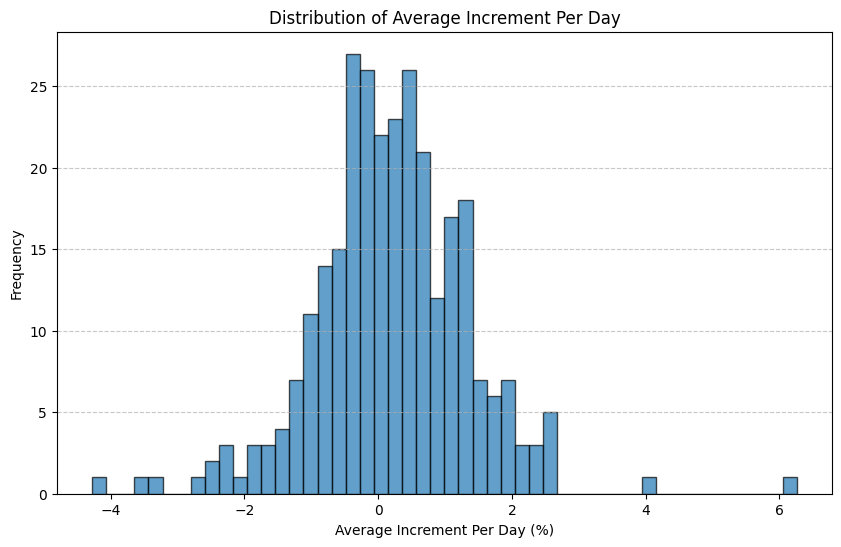

In [ ]:
# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(df_aapl["average_increment_per_day"].dropna(), bins=50, edgecolor='black', alpha=0.7)
plt.xlabel("Average Increment Per Day (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Average Increment Per Day")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


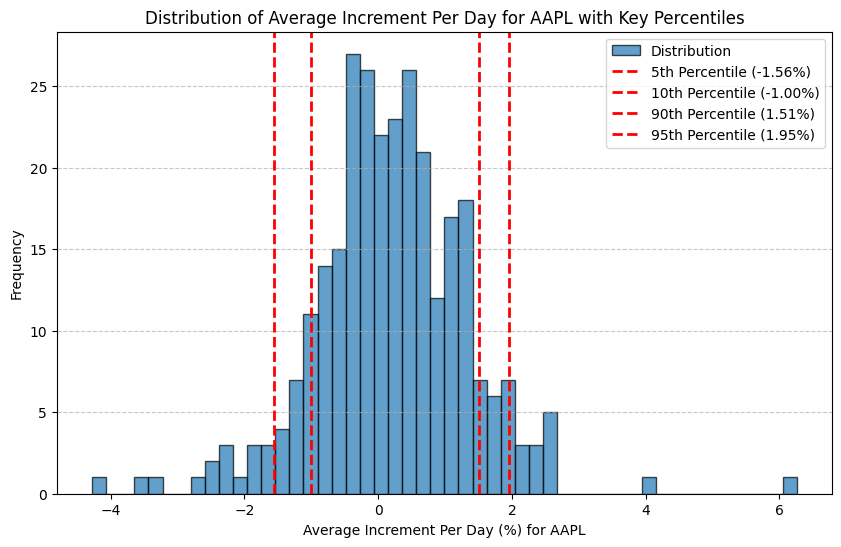

In [ ]:
visualize_histogram_with_percentiles(df_aapl)

# Creation of the Full Dataset

In [11]:
tickers = raw_df['SYM_ROOT'].unique()

In [12]:
all_dfs = []
for ticker in tickers:
  df_ticker = raw_df[raw_df['SYM_ROOT'] == ticker].copy()
  df_ticker["DATE"] = pd.to_datetime(df_ticker["DATE"])

  df_ticker = calculate_percentage_increment_for_pre_post(df_ticker)
  df_ticker = calculate_the_percentage_increment_open_close(df_ticker)

  all_dfs.append(df_ticker)

pre_processed_df = pd.concat(all_dfs)

In [13]:
pre_processed_df.head()

,SYM_ROOT,DATE,pre_market_volume,post_market_volume,DAY_OF_WEEK,OPEN,HIGH,LOW,CLOSE,VOLUME,...,OPEN_avg_3,OPEN_avg_3_increment,OPEN_avg_5,OPEN_avg_5_increment,CLOSE_avg_3,CLOSE_avg_3_increment,CLOSE_avg_5,CLOSE_avg_5_increment,HIGH_avg_3,HIGH_avg_3_increment
0,AAPL,2019-01-02,1448699.0,10818374.0,Wednesday,36.944462,37.889005,36.787037,37.667179,148158800.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAPL,2019-01-03,8702037.0,9788893.0,Thursday,34.342199,34.757226,33.869929,33.915249,365248800.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAPL,2019-01-04,3011205.0,9747041.0,Friday,34.473390,35.432244,34.299271,35.363071,234428400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAPL,2019-01-07,1613404.0,6495477.0,Monday,35.468017,35.499026,34.800159,35.284355,219111200.0,...,35.253350,0.608925,NaN,NaN,35.648500,-1.021487,NaN,NaN,36.026159,-1.463195
4,AAPL,2019-01-08,1997698.0,5557865.0,Tuesday,35.673145,36.212204,35.425085,35.956985,164101200.0,...,34.761202,2.623451,NaN,NaN,34.854225,3.163921,NaN,NaN,35.229499,2.789439


In [14]:
pre_processed_df.columns

Index(['SYM_ROOT', 'DATE', 'pre_market_volume', 'post_market_volume',
       'DAY_OF_WEEK', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME',
       'pre_market_volume_avg_3', 'pre_market_volume_avg_3_increment',
       'pre_market_volume_avg_5', 'pre_market_volume_avg_5_increment',
       'pre_market_volume_avg_9', 'pre_market_volume_avg_9_increment',
       'pre_market_volume_avg_12', 'pre_market_volume_avg_12_increment',
       'post_market_volume_avg_3', 'post_market_volume_avg_3_increment',
       'post_market_volume_avg_5', 'post_market_volume_avg_5_increment',
       'post_market_volume_avg_9', 'post_market_volume_avg_9_increment',
       'post_market_volume_avg_12', 'post_market_volume_avg_12_increment',
       'OPEN_avg_3', 'OPEN_avg_3_increment', 'OPEN_avg_5',
       'OPEN_avg_5_increment', 'CLOSE_avg_3', 'CLOSE_avg_3_increment',
       'CLOSE_avg_5', 'CLOSE_avg_5_increment', 'HIGH_avg_3',
       'HIGH_avg_3_increment'],
      dtype='object')

In [15]:
final_dataset = create_the_labels(pre_processed_df)

In [16]:
final_dataset.head()

,SYM_ROOT,DATE,pre_market_volume,post_market_volume,DAY_OF_WEEK,OPEN,HIGH,LOW,CLOSE,VOLUME,...,OPEN_avg_5,OPEN_avg_5_increment,CLOSE_avg_3,CLOSE_avg_3_increment,CLOSE_avg_5,CLOSE_avg_5_increment,HIGH_avg_3,HIGH_avg_3_increment,average_increment_per_day,label
0,AAPL,2019-01-02,1448699.0,10818374.0,Wednesday,36.944462,37.889005,36.787037,37.667179,148158800.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.956226,Buy
1,AAPL,2019-01-03,8702037.0,9788893.0,Thursday,34.342199,34.757226,33.869929,33.915249,365248800.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.243224,Neutral
2,AAPL,2019-01-04,3011205.0,9747041.0,Friday,34.473390,35.432244,34.299271,35.363071,234428400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.580776,Strong Buy
3,AAPL,2019-01-07,1613404.0,6495477.0,Monday,35.468017,35.499026,34.800159,35.284355,219111200.0,...,NaN,NaN,35.648500,-1.021487,NaN,NaN,36.026159,-1.463195,-0.517824,Neutral
4,AAPL,2019-01-08,1997698.0,5557865.0,Tuesday,35.673145,36.212204,35.425085,35.956985,164101200.0,...,NaN,NaN,34.854225,3.163921,NaN,NaN,35.229499,2.789439,0.795669,Neutral


In [17]:
final_dataset.columns

Index(['SYM_ROOT', 'DATE', 'pre_market_volume', 'post_market_volume',
       'DAY_OF_WEEK', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME',
       'pre_market_volume_avg_3', 'pre_market_volume_avg_3_increment',
       'pre_market_volume_avg_5', 'pre_market_volume_avg_5_increment',
       'pre_market_volume_avg_9', 'pre_market_volume_avg_9_increment',
       'pre_market_volume_avg_12', 'pre_market_volume_avg_12_increment',
       'post_market_volume_avg_3', 'post_market_volume_avg_3_increment',
       'post_market_volume_avg_5', 'post_market_volume_avg_5_increment',
       'post_market_volume_avg_9', 'post_market_volume_avg_9_increment',
       'post_market_volume_avg_12', 'post_market_volume_avg_12_increment',
       'OPEN_avg_3', 'OPEN_avg_3_increment', 'OPEN_avg_5',
       'OPEN_avg_5_increment', 'CLOSE_avg_3', 'CLOSE_avg_3_increment',
       'CLOSE_avg_5', 'CLOSE_avg_5_increment', 'HIGH_avg_3',
       'HIGH_avg_3_increment', 'average_increment_per_day', 'label'],
      dtype='object')

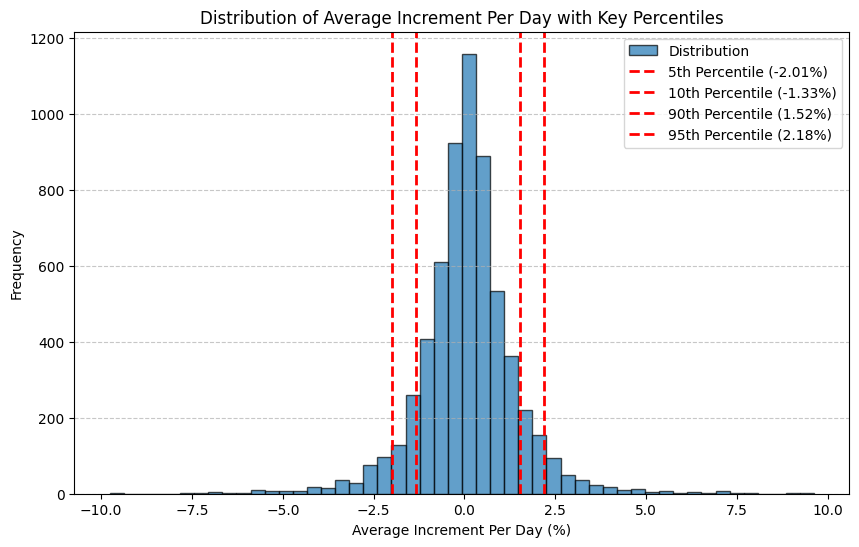

In [18]:
visualize_histogram_with_percentiles(final_dataset)

In [19]:
final_dataset.to_csv('/content/drive/MyDrive/Dataset/Final_Dataset/final_dataset_with_labels_v2.csv', index=False)

# RF and XGBoost
## Preparation for training and Training
### Start From here if don't want to do the preprocessing part

In [44]:
df_final = pd.read_csv('/content/drive/MyDrive/Dataset/Final_Dataset/final_dataset_with_labels_v2.csv')
df_final.tail(10)

,SYM_ROOT,DATE,pre_market_volume,post_market_volume,DAY_OF_WEEK,OPEN,HIGH,LOW,CLOSE,VOLUME,...,OPEN_avg_5,OPEN_avg_5_increment,CLOSE_avg_3,CLOSE_avg_3_increment,CLOSE_avg_5,CLOSE_avg_5_increment,HIGH_avg_3,HIGH_avg_3_increment,average_increment_per_day,label
6706,VTI,2020-02-14,113754.0,201722.0,Friday,159.039378,159.196933,158.464750,159.132050,2527800.0,...,157.558359,0.939981,158.585256,0.344795,157.925372,0.764081,159.017762,0.112673,0.058270,Neutral
6707,VTI,2020-02-18,289277.0,235444.0,Tuesday,158.733565,158.983791,158.047725,158.761368,2459400.0,...,158.031027,0.444557,158.980677,-0.137947,158.479596,0.177797,159.178395,-0.122255,0.017515,Neutral
6708,VTI,2020-02-19,134538.0,632488.0,Wednesday,159.335972,159.929125,159.196957,159.567673,2488100.0,...,158.585259,0.473381,158.921987,0.406291,158.729837,0.527838,159.175311,0.473575,0.145416,Neutral
6709,VTI,2020-02-20,148564.0,94489.0,Thursday,159.373060,159.808644,157.463834,159.085739,7061600.0,...,158.803979,0.358354,159.153697,-0.042699,159.054214,0.019820,159.369950,0.275268,-0.180282,Neutral
6710,VTI,2020-02-21,122289.0,134860.0,Friday,158.436999,158.511145,157.000451,157.454590,2983500.0,...,158.937444,-0.314869,159.138260,-1.057992,159.083875,-1.024167,159.573854,-0.665967,-0.620063,Neutral
6711,VTI,2020-02-24,895644.0,169321.0,Monday,152.459116,153.728832,151.615721,152.273758,8710900.0,...,158.983795,-4.103990,158.702667,-4.050914,158.800284,-4.109896,159.416305,-3.567686,-0.121579,Neutral
6712,VTI,2020-02-25,364623.0,334185.0,Tuesday,152.959566,153.283952,147.148521,147.621185,10112300.0,...,157.667742,-2.986138,156.271362,-5.535356,157.428625,-6.229769,157.349540,-2.583794,-3.490060,Strong Sell
6713,VTI,2020-02-26,440509.0,213189.0,Wednesday,148.297741,149.965989,146.434872,146.805588,8210300.0,...,156.512942,-5.248896,152.449844,-3.702370,155.200589,-5.409130,155.174643,-3.356640,-1.006188,Neutral
6714,VTI,2020-02-27,961030.0,331541.0,Thursday,143.691554,145.999299,140.317991,140.373611,14384200.0,...,154.305296,-6.878404,148.900177,-5.726364,152.648172,-8.041079,152.326258,-4.153557,-2.309073,Strong Sell
6715,VTI,2020-02-28,1682164.0,494707.0,Friday,135.702501,139.567268,134.664486,139.428253,22272400.0,...,151.168995,-10.231261,144.933462,-3.798438,148.905746,-6.364760,149.749747,-6.799664,2.745530,Strong Buy


In [45]:
df_final["SYM_ROOT"].value_counts().head(25)  # Check if some tickers have very few rows

,count
SYM_ROOT,
AAPL,292
JPM,292
VOO,292
V,292
TWLO,292
T,292
SQ,292
SHOP,292
MSFT,292


In [46]:
df_final['SYM_ROOT'].nunique()

23

In [47]:
selected_columns = [col for col in df_final.columns if col.endswith('increment')] + ['label','SYM_ROOT','DATE','DAY_OF_WEEK']

In [48]:
df_final = df_final[selected_columns]
df_final.head(20)

,pre_market_volume_avg_3_increment,pre_market_volume_avg_5_increment,pre_market_volume_avg_9_increment,pre_market_volume_avg_12_increment,post_market_volume_avg_3_increment,post_market_volume_avg_5_increment,post_market_volume_avg_9_increment,post_market_volume_avg_12_increment,OPEN_avg_3_increment,OPEN_avg_5_increment,CLOSE_avg_3_increment,CLOSE_avg_5_increment,HIGH_avg_3_increment,label,SYM_ROOT,DATE,DAY_OF_WEEK
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Buy,AAPL,2019-01-02,Wednesday
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Neutral,AAPL,2019-01-03,Thursday
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Strong Buy,AAPL,2019-01-04,Friday
3,-63.225697,NaN,NaN,NaN,-35.803409,NaN,NaN,NaN,0.608925,NaN,-1.021487,NaN,-1.463195,Neutral,AAPL,2019-01-07,Monday
4,-55.029240,NaN,NaN,NaN,-35.948170,NaN,NaN,NaN,2.623451,NaN,3.163921,NaN,2.789439,Neutral,AAPL,2019-01-08,Tuesday
5,11.487371,-26.637880,NaN,NaN,-35.010477,-44.318360,NaN,NaN,2.502305,1.994167,2.906425,2.610261,3.203462,Neutral,AAPL,2019-01-09,Wednesday
6,-38.909052,-65.238143,NaN,NaN,15.434141,-11.116322,NaN,NaN,1.768463,3.311409,2.081934,3.577420,1.478560,Neutral,AAPL,2019-01-10,Thursday
7,-46.995969,-51.247662,NaN,NaN,3.135610,-12.768617,NaN,NaN,1.166880,2.386897,-0.216222,0.981372,0.169450,Neutral,AAPL,2019-01-11,Friday
8,-31.777262,-35.676823,NaN,NaN,47.101313,43.214314,NaN,NaN,-0.902178,-0.090065,-2.046145,-1.065844,-1.815227,Neutral,AAPL,2019-01-14,Monday
9,-13.266353,-38.383528,-61.772624,NaN,-41.399760,-34.942030,-46.692474,NaN,-1.187987,-0.756836,0.684091,0.684098,0.268018,Buy,AAPL,2019-01-15,Tuesday


In [49]:
len(df_final)

6716

In [50]:
df_final.dropna(inplace=True)

In [51]:
df_final['label'].value_counts()

,count
label,
Neutral,4807
Sell,303
Strong Sell,297
Buy,283
Strong Buy,274


#### To convert Sell and Buy to Neutral

In [52]:
df_final.loc[df_final['label'].isin(['Sell', 'Buy']), 'label'] = 'Neutral'

#### To convert Strong Sell to Sell and Strong Buy to Buy

In [53]:
df_final.loc[(df_final['label']=='Strong Sell'), 'label'] = 'Sell'
df_final.loc[(df_final['label']=='Strong Buy'), 'label'] = 'Buy'

#### Solutions to the Class Imbalance Problem

##### Under Sampling + SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

In [ ]:
def smote_undersampling_pipeline(df):

  X = df.drop(columns=["label"])
  y = df["label"]

  label_encoder = LabelEncoder()

  y_encoded = label_encoder.fit_transform(y)

  # Print label mappings
  print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

  # Define the updated sampling strategy using the encoded values
  sampling_strategy_smote = {label_encoder.transform(['Sell'])[0]: 1500,
                           label_encoder.transform(['Buy'])[0]: 1500}

  sampling_strategy_undersampling = {label_encoder.transform(['Neutral'])[0]: 2500}


  print('Original Class Distribution: ', Counter(df['label']))

  smote = SMOTE(sampling_strategy=sampling_strategy_smote)
  undersampler = RandomUnderSampler(sampling_strategy=sampling_strategy_undersampling, random_state=42)

  #Pipeline for sampling using smote and undersampler
  pipeline = Pipeline([
      ('smote', smote),
      ('undersampler', undersampler)
  ])

  # Apply resampling
  X_resampled, y_resampled = pipeline.fit_resample(X, y_encoded)

  # Convert resampled target variable back to original labels
  y_resampled = label_encoder.inverse_transform(y_resampled)

  # Check the new class distribution after balancing
  print("New class distribution:", Counter(y_resampled))

  # Save the balanced dataset
  balanced_df = pd.DataFrame(X_resampled, columns=X.columns)
  balanced_df["label"] = y_resampled

  return balanced_df

### Separate the Train and Test Set

In [54]:
train_list = []
test_list = []


In [55]:
tickers = df_final['SYM_ROOT'].unique()

In [56]:
df_final.head(20)

,pre_market_volume_avg_3_increment,pre_market_volume_avg_5_increment,pre_market_volume_avg_9_increment,pre_market_volume_avg_12_increment,post_market_volume_avg_3_increment,post_market_volume_avg_5_increment,post_market_volume_avg_9_increment,post_market_volume_avg_12_increment,OPEN_avg_3_increment,OPEN_avg_5_increment,CLOSE_avg_3_increment,CLOSE_avg_5_increment,HIGH_avg_3_increment,label,SYM_ROOT,DATE,DAY_OF_WEEK
12,524.067735,523.122514,365.118076,201.914400,69.733774,39.406927,36.501379,14.046832,3.267384,3.444182,1.420642,2.341537,1.437030,Neutral,AAPL,2019-01-18,Friday
13,-48.075876,-29.972608,-22.703965,-41.745528,52.371937,48.654150,52.240221,35.420510,0.957461,2.108645,-1.650897,-0.543656,-0.260903,Neutral,AAPL,2019-01-22,Tuesday
14,-68.204098,-57.669377,-49.963896,-52.134422,-37.428227,-28.650402,-30.023232,-33.030948,-1.209115,-0.092031,-0.905615,-0.567188,-1.450436,Neutral,AAPL,2019-01-23,Wednesday
15,-73.828319,-64.868288,-54.422623,-56.503352,-8.860499,3.859727,3.657624,5.919859,-1.224187,-0.617778,-1.280052,-1.463517,-1.343256,Neutral,AAPL,2019-01-24,Thursday
16,50.785672,-23.696211,-2.461853,-6.037713,-26.699061,-24.028880,-22.013322,-20.306094,0.380894,0.132653,2.904830,2.096798,1.724012,Neutral,AAPL,2019-01-25,Friday
17,62.722409,-20.106442,4.925255,7.214809,-0.015441,-19.664571,-14.287477,-13.027904,0.782746,0.167152,0.973327,0.903796,0.265082,Neutral,AAPL,2019-01-28,Monday
18,-29.374462,-25.483500,-45.187380,-39.349663,110.837371,94.214227,102.293556,92.091134,0.724151,0.684338,-0.582734,-0.074936,1.162208,Neutral,AAPL,2019-01-29,Tuesday
19,190.677544,248.694129,136.528389,165.590581,-12.074901,-2.301137,-3.380764,-1.705248,4.754898,5.216700,5.762278,6.563417,5.471986,Neutral,AAPL,2019-01-30,Wednesday
20,-38.211685,-23.059142,-31.975466,-22.589815,80.486704,102.293243,109.602108,114.458307,4.847580,5.818737,4.848511,5.785012,5.490949,Neutral,AAPL,2019-01-31,Thursday
21,-52.969758,-48.067383,-52.213666,-44.936642,8.430136,37.375786,49.015843,65.641798,3.144492,4.758562,2.711920,4.019092,2.769205,Neutral,AAPL,2019-02-01,Friday


In [57]:
# Ensure the dataset is sorted by SYM_ROOT and DATE
df_final = df_final.sort_values(by=['SYM_ROOT', 'DATE']).reset_index(drop=True)

In [58]:
for ticker in tickers:
    ticker_df = df_final[df_final['SYM_ROOT'] == ticker]

    # Split ticker data into train and test (80-20 split, stratify if needed)
    train, test = train_test_split(ticker_df, test_size=0.2)

    # Append to respective lists
    train_list.append(train)
    test_list.append(test)

# Concatenate all train and test data
train_df = pd.concat(train_list, ignore_index=True)
test_df = pd.concat(test_list, ignore_index=True)

In [59]:
# Ensure the dataset is sorted by SYM_ROOT and DATE
train_df = train_df.sort_values(by=['SYM_ROOT', 'DATE']).reset_index(drop=True)
test_df = test_df.sort_values(by=['SYM_ROOT', 'DATE']).reset_index(drop=True)

##### Run this cell to apply the preferred sampling technique.

In [60]:
print("Train set current label distribution :", Counter(train_df['label']))
print("Test set current label distribution :", Counter(test_df['label']))

Train set current label distribution : Counter({'Neutral': 4318, 'Sell': 236, 'Buy': 216})
Test set current label distribution : Counter({'Neutral': 1075, 'Sell': 61, 'Buy': 58})


Apply one hot encoding to SYM_ROOT and drop the date column before applying sampling techniques.

In [61]:
train_df = preprocess_for_ml(train_df, ['SYM_ROOT','DAY_OF_WEEK'])
test_df = preprocess_for_ml(test_df, ['SYM_ROOT','DAY_OF_WEEK'])

In [62]:
train_df = train_df.drop('DATE', axis=1)
test_df = test_df.drop('DATE', axis=1)

In [63]:
train_df.columns

Index(['pre_market_volume_avg_3_increment',
       'pre_market_volume_avg_5_increment',
       'pre_market_volume_avg_9_increment',
       'pre_market_volume_avg_12_increment',
       'post_market_volume_avg_3_increment',
       'post_market_volume_avg_5_increment',
       'post_market_volume_avg_9_increment',
       'post_market_volume_avg_12_increment', 'OPEN_avg_3_increment',
       'OPEN_avg_5_increment', 'CLOSE_avg_3_increment',
       'CLOSE_avg_5_increment', 'HIGH_avg_3_increment', 'label',
       'SYM_ROOT_AAPL', 'SYM_ROOT_ABBV', 'SYM_ROOT_AMZN', 'SYM_ROOT_BA',
       'SYM_ROOT_BABA', 'SYM_ROOT_BAC', 'SYM_ROOT_BRK', 'SYM_ROOT_CRM',
       'SYM_ROOT_DIS', 'SYM_ROOT_GOOG', 'SYM_ROOT_JNJ', 'SYM_ROOT_JPM',
       'SYM_ROOT_KO', 'SYM_ROOT_MA', 'SYM_ROOT_MSFT', 'SYM_ROOT_SHOP',
       'SYM_ROOT_SQ', 'SYM_ROOT_T', 'SYM_ROOT_TWLO', 'SYM_ROOT_V',
       'SYM_ROOT_VOO', 'SYM_ROOT_VTI', 'DAY_OF_WEEK_Friday',
       'DAY_OF_WEEK_Monday', 'DAY_OF_WEEK_Thursday', 'DAY_OF_WEEK_Tuesday',
     

In [64]:
train_df = smote_undersampling_pipeline(train_df)

NameError: name 'smote_undersampling_pipeline' is not defined

In [65]:
print("NaN values in train dataset before resampling:")
print(train_df.isnull().sum())

NaN values in train dataset before resampling:
pre_market_volume_avg_3_increment      0
pre_market_volume_avg_5_increment      0
pre_market_volume_avg_9_increment      0
pre_market_volume_avg_12_increment     0
post_market_volume_avg_3_increment     0
post_market_volume_avg_5_increment     0
post_market_volume_avg_9_increment     0
post_market_volume_avg_12_increment    0
OPEN_avg_3_increment                   0
OPEN_avg_5_increment                   0
CLOSE_avg_3_increment                  0
CLOSE_avg_5_increment                  0
HIGH_avg_3_increment                   0
label                                  0
SYM_ROOT_AAPL                          0
SYM_ROOT_ABBV                          0
SYM_ROOT_AMZN                          0
SYM_ROOT_BA                            0
SYM_ROOT_BABA                          0
SYM_ROOT_BAC                           0
SYM_ROOT_BRK                           0
SYM_ROOT_CRM                           0
SYM_ROOT_DIS                           0
SYM_ROOT_G

In [ ]:
# train_df['DATE'].head(100)

In [66]:
test_df.columns

Index(['pre_market_volume_avg_3_increment',
       'pre_market_volume_avg_5_increment',
       'pre_market_volume_avg_9_increment',
       'pre_market_volume_avg_12_increment',
       'post_market_volume_avg_3_increment',
       'post_market_volume_avg_5_increment',
       'post_market_volume_avg_9_increment',
       'post_market_volume_avg_12_increment', 'OPEN_avg_3_increment',
       'OPEN_avg_5_increment', 'CLOSE_avg_3_increment',
       'CLOSE_avg_5_increment', 'HIGH_avg_3_increment', 'label',
       'SYM_ROOT_AAPL', 'SYM_ROOT_ABBV', 'SYM_ROOT_AMZN', 'SYM_ROOT_BA',
       'SYM_ROOT_BABA', 'SYM_ROOT_BAC', 'SYM_ROOT_BRK', 'SYM_ROOT_CRM',
       'SYM_ROOT_DIS', 'SYM_ROOT_GOOG', 'SYM_ROOT_JNJ', 'SYM_ROOT_JPM',
       'SYM_ROOT_KO', 'SYM_ROOT_MA', 'SYM_ROOT_MSFT', 'SYM_ROOT_SHOP',
       'SYM_ROOT_SQ', 'SYM_ROOT_T', 'SYM_ROOT_TWLO', 'SYM_ROOT_V',
       'SYM_ROOT_VOO', 'SYM_ROOT_VTI', 'DAY_OF_WEEK_Friday',
       'DAY_OF_WEEK_Monday', 'DAY_OF_WEEK_Thursday', 'DAY_OF_WEEK_Tuesday',
     

## Training

In [67]:
X_train = train_df.drop('label', axis=1)
y_train = train_df['label']

X_test = test_df.drop('label', axis=1)
y_test = test_df['label']

# Convert target to numerical values (e.g., Strong Buy = 2, Neutral = 1, Strong Sell = 0)
label_mapping = {'Buy': 2, 'Neutral': 1, 'Sell': 0}
y_train = y_train.map(label_mapping)
y_test = y_test.map(label_mapping)

In [68]:
# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Train XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

# Evaluate Random Forest
print("Random Forest Results:")
print("Accuracy:", accuracy_score(y_test, rf_predictions))
print("Classification Report:\n", classification_report(y_test, rf_predictions))

# Evaluate XGBoost
print("XGBoost Results:")
print("Accuracy:", accuracy_score(y_test, xgb_predictions))
print("Classification Report:\n", classification_report(y_test, xgb_predictions))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:49:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Random Forest Results:
Accuracy: 0.9413735343383585
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.54      0.68        61
           1       0.94      1.00      0.97      1075
           2       0.91      0.36      0.52        58

    accuracy                           0.94      1194
   macro avg       0.92      0.63      0.72      1194
weighted avg       0.94      0.94      0.93      1194

XGBoost Results:
Accuracy: 0.9606365159128978
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.77      0.82        61
           1       0.97      0.99      0.98      1075
           2       0.88      0.64      0.74        58

    accuracy                           0.96      1194
   macro avg       0.91      0.80      0.85      1194
weighted avg       0.96      0.96      0.96      1194



# CNN + LSTM
## Preparation of Data

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [27]:
df_final = pd.read_csv('/content/drive/MyDrive/Dataset/Final_Dataset/final_dataset_with_labels_v2.csv')
df_final.tail(10)

,SYM_ROOT,DATE,pre_market_volume,post_market_volume,DAY_OF_WEEK,OPEN,HIGH,LOW,CLOSE,VOLUME,...,OPEN_avg_5,OPEN_avg_5_increment,CLOSE_avg_3,CLOSE_avg_3_increment,CLOSE_avg_5,CLOSE_avg_5_increment,HIGH_avg_3,HIGH_avg_3_increment,average_increment_per_day,label
6706,VTI,2020-02-14,113754.0,201722.0,Friday,159.039378,159.196933,158.464750,159.132050,2527800.0,...,157.558359,0.939981,158.585256,0.344795,157.925372,0.764081,159.017762,0.112673,0.058270,Neutral
6707,VTI,2020-02-18,289277.0,235444.0,Tuesday,158.733565,158.983791,158.047725,158.761368,2459400.0,...,158.031027,0.444557,158.980677,-0.137947,158.479596,0.177797,159.178395,-0.122255,0.017515,Neutral
6708,VTI,2020-02-19,134538.0,632488.0,Wednesday,159.335972,159.929125,159.196957,159.567673,2488100.0,...,158.585259,0.473381,158.921987,0.406291,158.729837,0.527838,159.175311,0.473575,0.145416,Neutral
6709,VTI,2020-02-20,148564.0,94489.0,Thursday,159.373060,159.808644,157.463834,159.085739,7061600.0,...,158.803979,0.358354,159.153697,-0.042699,159.054214,0.019820,159.369950,0.275268,-0.180282,Neutral
6710,VTI,2020-02-21,122289.0,134860.0,Friday,158.436999,158.511145,157.000451,157.454590,2983500.0,...,158.937444,-0.314869,159.138260,-1.057992,159.083875,-1.024167,159.573854,-0.665967,-0.620063,Neutral
6711,VTI,2020-02-24,895644.0,169321.0,Monday,152.459116,153.728832,151.615721,152.273758,8710900.0,...,158.983795,-4.103990,158.702667,-4.050914,158.800284,-4.109896,159.416305,-3.567686,-0.121579,Neutral
6712,VTI,2020-02-25,364623.0,334185.0,Tuesday,152.959566,153.283952,147.148521,147.621185,10112300.0,...,157.667742,-2.986138,156.271362,-5.535356,157.428625,-6.229769,157.349540,-2.583794,-3.490060,Strong Sell
6713,VTI,2020-02-26,440509.0,213189.0,Wednesday,148.297741,149.965989,146.434872,146.805588,8210300.0,...,156.512942,-5.248896,152.449844,-3.702370,155.200589,-5.409130,155.174643,-3.356640,-1.006188,Neutral
6714,VTI,2020-02-27,961030.0,331541.0,Thursday,143.691554,145.999299,140.317991,140.373611,14384200.0,...,154.305296,-6.878404,148.900177,-5.726364,152.648172,-8.041079,152.326258,-4.153557,-2.309073,Strong Sell
6715,VTI,2020-02-28,1682164.0,494707.0,Friday,135.702501,139.567268,134.664486,139.428253,22272400.0,...,151.168995,-10.231261,144.933462,-3.798438,148.905746,-6.364760,149.749747,-6.799664,2.745530,Strong Buy


In [28]:
df_final = preprocess_for_ml(df_final, ['SYM_ROOT','DAY_OF_WEEK'])

#### To convert Strong Sell to Sell and Strong Buy to Buy

In [29]:
df_final.loc[(df_final['label']=='Strong Sell'), 'label'] = 'Sell'
df_final.loc[(df_final['label']=='Strong Buy'), 'label'] = 'Buy'

In [30]:
# Select Features (excluding label column)
features = [
    'pre_market_volume_avg_3_increment', 'pre_market_volume_avg_5_increment',
    'pre_market_volume_avg_9_increment', 'pre_market_volume_avg_12_increment',
    'post_market_volume_avg_3_increment', 'post_market_volume_avg_5_increment',
    'post_market_volume_avg_9_increment', 'post_market_volume_avg_12_increment',
    'OPEN_avg_3_increment', 'OPEN_avg_5_increment', 'CLOSE_avg_3_increment',
    'CLOSE_avg_5_increment', 'HIGH_avg_3_increment',
] + [col for col in df_final.columns if col.startswith('SYM_ROOT') or col.startswith('DAY_OF_WEEK')]

# Target Variable (label)
target = 'label'

In [31]:
# Convert to NumPy arrays
X = df_final[features].values
y = df_final[target].values

In [32]:
# Encode labels (Buy=2, Sell=0, Neutral=1)
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [33]:
# Split dataset (Train-Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape Data for CNN-LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [34]:
# CNN - LSTM Model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # Output 3 classes (Buy, Sell, Neutral)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [35]:
# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [36]:
# Train the Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - accuracy: 0.0936 - loss: nan - val_accuracy: 0.0930 - val_loss: nan
Epoch 2/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.0919 - loss: nan - val_accuracy: 0.0930 - val_loss: nan
Epoch 3/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - accuracy: 0.0972 - loss: nan - val_accuracy: 0.0930 - val_loss: nan
Epoch 4/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 23s 78ms/step - accuracy: 0.0901 - loss: nan - val_accuracy: 0.0930 - val_loss: nan
Epoch 5/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.0902 - loss: nan - val_accuracy: 0.0930 - val_loss: nan
Epoch 6/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.0927 - loss: nan - val_accuracy: 0.0930 - val_loss: nan
Epoch 7/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - accuracy: 0.0980 - loss: nan - val_accuracy: 0.0930 - val_loss: nan
Epoch 8/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.0921 - loss: nan - val_accuracy: 0.0930 - val_loss: nan
Epoch 9/

In [37]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0969 - loss: nan
Test Accuracy: 0.0930


In [39]:
# Predict
import numpy as np
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_classes, target_names=encoder.classes_))

              precision    recall  f1-score   support

         Buy       0.09      1.00      0.17       125
     Neutral       0.00      0.00      0.00      1094
        Sell       0.00      0.00      0.00       125

    accuracy                           0.09      1344
   macro avg       0.03      0.33      0.06      1344
weighted avg       0.01      0.09      0.02      1344



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
